# TODO:
 1. Create (small) Dataset for comparison of different data imputation techniques
 2. Run several imputation methods
 3. Compare them in time and accuracy
 4. Write first chapter of thesis!

Imputation techniques:
* mean / median
* k-NN
* MICE
* Maybe some additional methods at a later point


In [1]:
import sys
import os
import time

import numpy as np
import pandas as pd
import missingno as msno
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer

# explicitly require this experimental feature
from sklearn.experimental import enable_iterative_imputer  # noqa
# now you can import normally from sklearn.impute
from sklearn.impute import IterativeImputer

#from sklearn.experimental import enable_iterative_imputer   #line needed because something is deprecated
from sklearn import linear_model

from IPython.core.display_functions import display

#from NDBC_Buoy_Data import myLibrary as mL
dir_root =os.path.abspath(os.path.join(os.getcwd(), os.path.pardir))
sys.path.append(dir_root)
import myLibrary as mL

----

# Build Dataset

Find station and year with lowest num of NaN values!

In [2]:
stations = mL.stations_GOM
years = ["2010", "2011", "2012", "2013", "2014", "2015", "2016", "2017", "2018", "2019", "2020" "2021", "2022"]

NaN_statistic = pd.DataFrame()
for year in years:
    for stationID in mL.cleaned_stations_GOM:
        data = mL.get_data_file(stationID, year)
        if data is not None:
            data = mL.df_modification(data)[1]
            data = mL.replace_with_NaN(data)
            num_values, num_NaN_percentage, NaN_by_feature = mL.print_NaN_statistic(data, "", silent=True)

            new_row = pd.DataFrame({
                    "StationID": [stationID],
                    "Year": [year],
                    "#NaN in %": [num_NaN_percentage]
                })
            NaN_statistic = pd.concat([NaN_statistic, new_row])

Failed to get file: HTTP Error 404: Not Found
Failed to get file: HTTP Error 404: Not Found
Failed to get file: HTTP Error 404: Not Found
Failed to get file: HTTP Error 404: Not Found
Failed to get file: HTTP Error 404: Not Found
Failed to get file: HTTP Error 404: Not Found
Failed to get file: HTTP Error 404: Not Found
Failed to get file: HTTP Error 404: Not Found
Failed to get file: HTTP Error 404: Not Found
Failed to get file: HTTP Error 404: Not Found
Failed to get file: HTTP Error 404: Not Found
Failed to get file: HTTP Error 404: Not Found
Failed to get file: HTTP Error 404: Not Found
Failed to get file: HTTP Error 404: Not Found
Failed to get file: HTTP Error 404: Not Found
Failed to get file: HTTP Error 404: Not Found
Failed to get file: HTTP Error 404: Not Found
Failed to get file: HTTP Error 404: Not Found
Failed to get file: HTTP Error 404: Not Found
Failed to get file: HTTP Error 404: Not Found
Failed to get file: HTTP Error 404: Not Found
Failed to get file: HTTP Error 404

KeyboardInterrupt: 

In [4]:
NaN_statistic

,StationID,Year,#NaN in %
0,41112,2010,61.86
0,42001,2010,54.82
0,42002,2010,39.09
0,42012,2010,17.21
0,42013,2010,81.65
...,...,...,...
0,vcat2,2019,56.10
0,venf1,2019,46.48
0,wiwf1,2019,91.53
0,wplf1,2019,91.53


As we can see, the dataset of station 42001 of the year 2016 includes the lowest amount of NaN values, so lets continue with that file.

In [4]:
test_data = mL.get_data_file("42001", "2016")
test_data = mL.df_modification(test_data)[1]
test_data = mL.replace_with_NaN(test_data)
test_data

,WDIR_42001,WSPD_42001,GST_42001,WVHT_42001,DPD_42001,APD_42001,MWD_42001,PRES_42001,ATMP_42001,WTMP_42001,DEWP_42001,VIS_42001,TIDE_42001
timestamp,,,,,,,,,,,,,
2016-03-30 09:50:00,115,9.2,10.8,1.19,5.00,3.98,93,1013.2,24.3,23.9,23.2,NaN,NaN
2016-03-30 10:50:00,114,7.1,8.5,1.17,5.56,4.47,95,1013.5,24.4,23.9,23.2,NaN,NaN
2016-03-30 11:50:00,116,7.8,9.0,1.20,5.56,4.48,102,1013.7,24.4,23.9,23.0,NaN,NaN
2016-03-30 12:50:00,116,7.4,8.5,1.24,6.25,4.56,94,1014.4,24.5,23.9,23.1,NaN,NaN
2016-03-30 13:50:00,118,7.7,9.0,1.28,5.88,4.73,95,1014.9,24.7,23.9,23.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-31 18:50:00,166,9.2,11.3,1.52,6.67,4.81,76,1016.2,24.2,24.7,18.9,NaN,NaN
2016-12-31 19:50:00,155,9.3,11.1,1.68,5.56,4.93,138,1014.9,24.3,24.7,19.0,NaN,NaN
2016-12-31 20:50:00,161,9.2,10.5,1.58,6.25,4.90,100,1014.4,24.5,24.8,19.5,NaN,NaN


<AxesSubplot: >

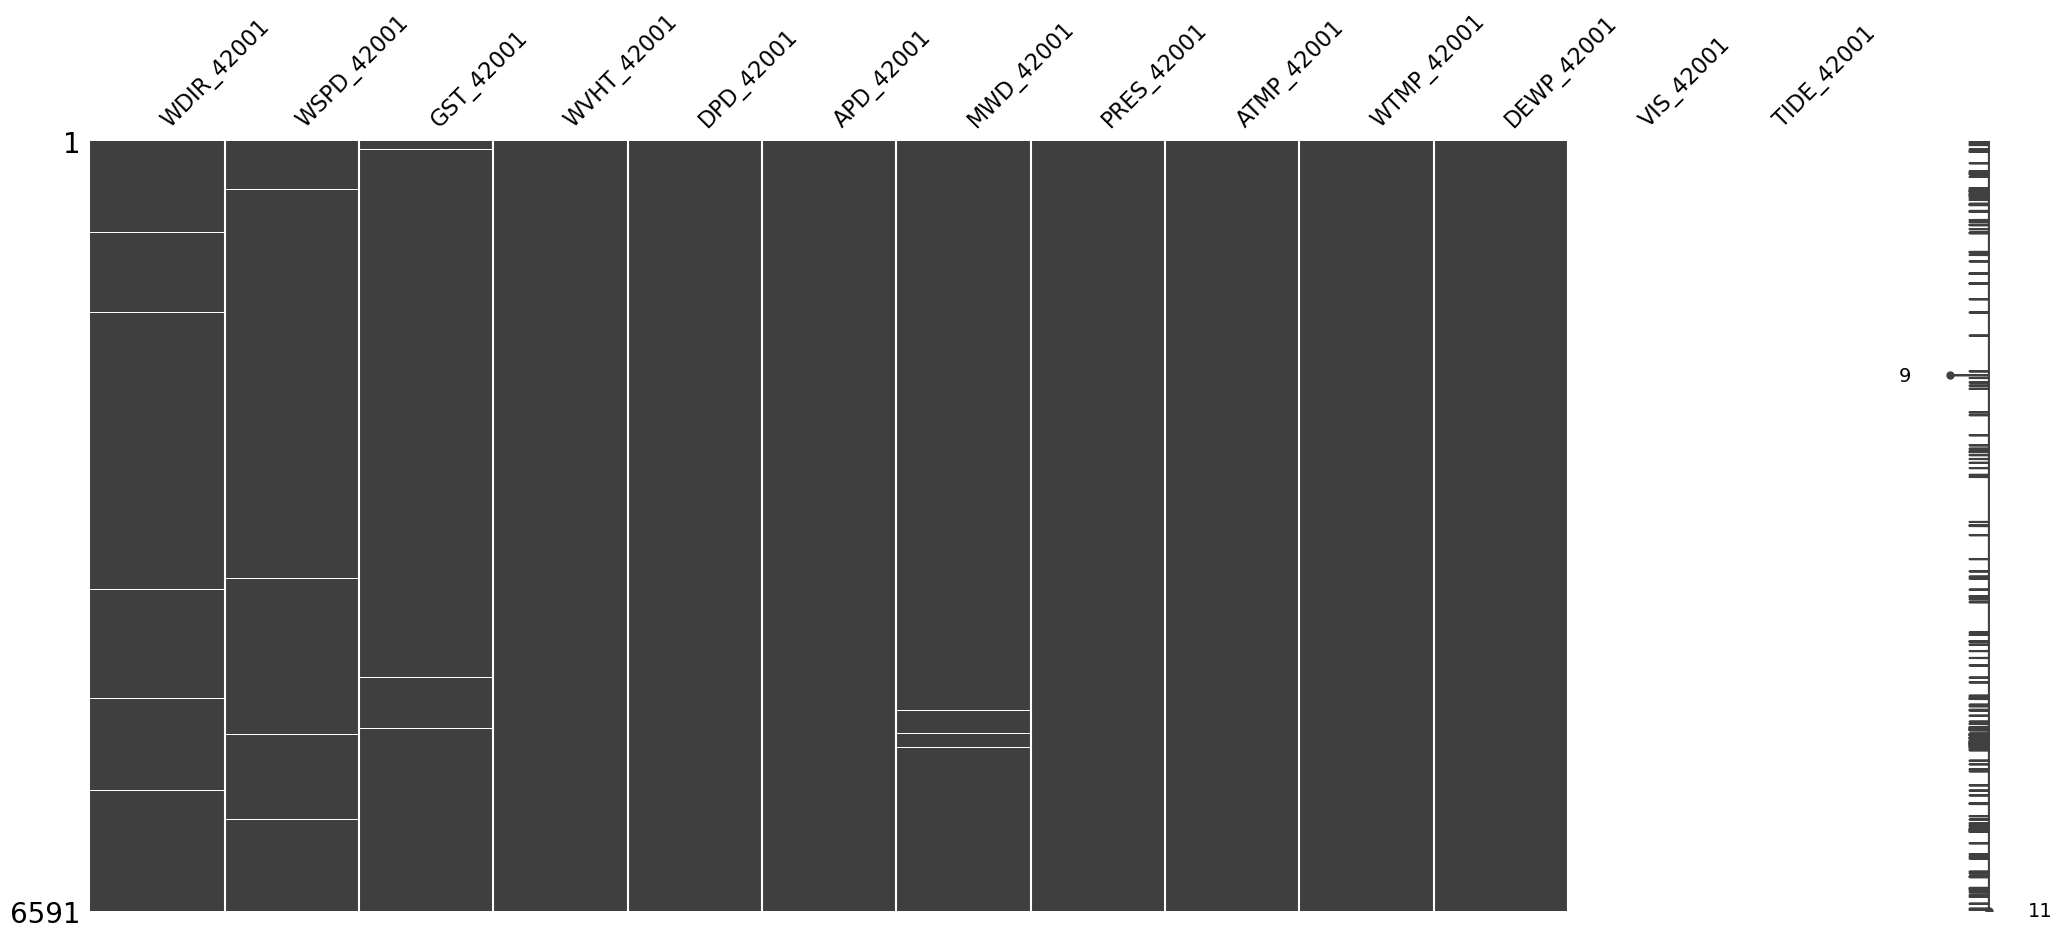

In [5]:
msno.matrix(test_data)

The graph shows that the features VIS and TIDE do not provide any values, so lets those colums without any values!

In [6]:
#test_data = mL.drop_NaN_rows_and_cols(test_data) #ORIGINAL!
test_data = test_data.dropna(axis=1, how='all')  # drop cols if all values are NaN  #ATTENTION: CODE CHANGED WITHOUT EXECUTION!!!!
test_data.head()

,WDIR_42001,WSPD_42001,GST_42001,WVHT_42001,DPD_42001,APD_42001,MWD_42001,PRES_42001,ATMP_42001,WTMP_42001,DEWP_42001
timestamp,,,,,,,,,,,
2016-03-30 09:50:00,115,9.2,10.8,1.19,5.00,3.98,93,1013.2,24.3,23.9,23.2
2016-03-30 10:50:00,114,7.1,8.5,1.17,5.56,4.47,95,1013.5,24.4,23.9,23.2
2016-03-30 11:50:00,116,7.8,9.0,1.20,5.56,4.48,102,1013.7,24.4,23.9,23.0
2016-03-30 12:50:00,116,7.4,8.5,1.24,6.25,4.56,94,1014.4,24.5,23.9,23.1
2016-03-30 13:50:00,118,7.7,9.0,1.28,5.88,4.73,95,1014.9,24.7,23.9,23.0


In [7]:
num_values, num_NaN_percentage, NaN_by_feature = mL.print_NaN_statistic(test_data, "") #unneeded


 
number of values:  72501
number of NaN values:  175 ( 0.24 %)



In [8]:
NaN_by_feature

,Feature,#NaN,%NaN
0,WDIR_42001,49,0.74
1,WSPD_42001,22,0.33
2,GST_42001,38,0.58
3,WVHT_42001,0,0.00
4,DPD_42001,0,0.00
5,APD_42001,0,0.00
6,MWD_42001,66,1.00
7,PRES_42001,0,0.00
8,ATMP_42001,0,0.00
9,WTMP_42001,0,0.00


We do still have some NaN values ... now we delete those rows!

In [9]:
test_data = test_data.dropna(axis=0, how="any")  # drop rows if any values is NaN
test_data

,WDIR_42001,WSPD_42001,GST_42001,WVHT_42001,DPD_42001,APD_42001,MWD_42001,PRES_42001,ATMP_42001,WTMP_42001,DEWP_42001
timestamp,,,,,,,,,,,
2016-03-30 09:50:00,115,9.2,10.8,1.19,5.00,3.98,93,1013.2,24.3,23.9,23.2
2016-03-30 10:50:00,114,7.1,8.5,1.17,5.56,4.47,95,1013.5,24.4,23.9,23.2
2016-03-30 11:50:00,116,7.8,9.0,1.20,5.56,4.48,102,1013.7,24.4,23.9,23.0
2016-03-30 12:50:00,116,7.4,8.5,1.24,6.25,4.56,94,1014.4,24.5,23.9,23.1
2016-03-30 13:50:00,118,7.7,9.0,1.28,5.88,4.73,95,1014.9,24.7,23.9,23.0
...,...,...,...,...,...,...,...,...,...,...,...
2016-12-31 18:50:00,166,9.2,11.3,1.52,6.67,4.81,76,1016.2,24.2,24.7,18.9
2016-12-31 19:50:00,155,9.3,11.1,1.68,5.56,4.93,138,1014.9,24.3,24.7,19.0
2016-12-31 20:50:00,161,9.2,10.5,1.58,6.25,4.90,100,1014.4,24.5,24.8,19.5


In [21]:
mL.print_NaN_statistic(test_data, "Are all NaN values removed?")


 Are all NaN values removed?
number of values:  70587
number of NaN values:  0 ( 0.0 %)



(70587,
 0.0,
        Feature  #NaN  %NaN
 0   WDIR_42001     0   0.0
 1   WSPD_42001     0   0.0
 2    GST_42001     0   0.0
 3   WVHT_42001     0   0.0
 4    DPD_42001     0   0.0
 5    APD_42001     0   0.0
 6    MWD_42001     0   0.0
 7   PRES_42001     0   0.0
 8   ATMP_42001     0   0.0
 9   WTMP_42001     0   0.0
 10  DEWP_42001     0   0.0)

--> All NaN values have successfully been removed. That means a "ground truth" dataset has successfully been created!

In [23]:
test_data.to_pickle("../data/NaN_ground_truth")

---

# Prepare evaluation
- exchange x% of the values at a random positon with NaN

In [27]:
test_data = pd.read_pickle("../../data/NaN_ground_truth").astype(float)

In [35]:
test_data

,WDIR_42001,WSPD_42001,GST_42001,WVHT_42001,DPD_42001,APD_42001,MWD_42001,PRES_42001,ATMP_42001,WTMP_42001,DEWP_42001
0,0.317549,0.621622,0.563158,0.268571,0.146277,0.192771,0.256267,0.376068,0.386555,0.055556,0.73125
1,0.314763,0.479730,0.442105,0.262857,0.176064,0.291165,0.261838,0.388889,0.394958,0.055556,0.73125
2,0.320334,0.527027,0.468421,0.271429,0.176064,0.293173,0.281337,0.397436,0.394958,0.055556,0.71875
3,0.320334,0.500000,0.442105,0.282857,0.212766,0.309237,0.259053,0.427350,0.403361,0.055556,0.72500
4,0.325905,0.520270,0.468421,0.294286,0.193085,0.343373,0.261838,0.448718,0.420168,0.055556,0.71875
...,...,...,...,...,...,...,...,...,...,...,...
6412,0.459610,0.621622,0.589474,0.362857,0.235106,0.359438,0.208914,0.504274,0.378151,0.129630,0.46250
6413,0.428969,0.628378,0.578947,0.408571,0.176064,0.383534,0.381616,0.448718,0.386555,0.129630,0.46875
6414,0.445682,0.621622,0.547368,0.380000,0.212766,0.377510,0.275766,0.427350,0.403361,0.138889,0.50000
6415,0.470752,0.581081,0.526316,0.385714,0.176064,0.363454,0.350975,0.431624,0.403361,0.138889,0.52500


In [29]:
mL.print_NaN_statistic(test_data, "Are all NaN values removed?")


 Are all NaN values removed?
number of values:  70587
number of NaN values:  0 ( 0.0 %)



(70587,
 0.0,
        Feature  #NaN  %NaN
 0   WDIR_42001     0   0.0
 1   WSPD_42001     0   0.0
 2    GST_42001     0   0.0
 3   WVHT_42001     0   0.0
 4    DPD_42001     0   0.0
 5    APD_42001     0   0.0
 6    MWD_42001     0   0.0
 7   PRES_42001     0   0.0
 8   ATMP_42001     0   0.0
 9   WTMP_42001     0   0.0
 10  DEWP_42001     0   0.0)

# Data normalization

In [34]:
scaler = MinMaxScaler()
test_data = pd.DataFrame(scaler.fit_transform(test_data), columns = test_data.columns)
test_data.head()

,WDIR_42001,WSPD_42001,GST_42001,WVHT_42001,DPD_42001,APD_42001,MWD_42001,PRES_42001,ATMP_42001,WTMP_42001,DEWP_42001
0,0.317549,0.621622,0.563158,0.268571,0.146277,0.192771,0.256267,0.376068,0.386555,0.055556,0.73125
1,0.314763,0.479730,0.442105,0.262857,0.176064,0.291165,0.261838,0.388889,0.394958,0.055556,0.73125
2,0.320334,0.527027,0.468421,0.271429,0.176064,0.293173,0.281337,0.397436,0.394958,0.055556,0.71875
3,0.320334,0.500000,0.442105,0.282857,0.212766,0.309237,0.259053,0.427350,0.403361,0.055556,0.72500
4,0.325905,0.520270,0.468421,0.294286,0.193085,0.343373,0.261838,0.448718,0.420168,0.055556,0.71875


## TODO:

- Evaluate data imputation techniques depending on % of NaN values in the perspective of execution time (clock time or CPU time?) and accuracy
- Also consider executing it on Google Colab for better comparability than using M1 chip!

----
# Data Imputation Techniques:

All functions should take a dataframe with NaN values as input and return a dataframe with the imputed values. Those methods must be useable as a parameter for the evaluation function!

In [36]:
def imputation_mean(data):
    return data.fillna(data.mean()) #replace all NaN values with the column-mean

In [37]:
def imputation_median(data):
    return data.fillna(data.median()) #replace all NaN values with the column-median

In [38]:
def imputation_knn(k):
    def imputation(data):
        imputer_knn = KNNImputer(n_neighbors=k, weights='uniform', metric='nan_euclidean')
        return pd.DataFrame(imputer_knn.fit_transform(data),columns = data.columns)
    return imputation

In [39]:
def imputation_mice(data):
    # Define MICE Imputer
    imputer_mice = IterativeImputer(
        estimator=linear_model.BayesianRidge(),
        n_nearest_features=None,
        imputation_order='ascending',
        max_iter=30,
        verbose=0)

    imputer_mice.fit(data)   #fit imputer on the dataset
    imputed_data = pd.DataFrame(imputer_mice.transform(data)) #transform the dataset #What exactly happens here?
    imputed_data.columns=data.columns
    return imputed_data

    #ISSUE: Column name and index got lost!

----
# Evaluation:

As Accuracy I use MSE (=Mean Square Error) since it is also used in the paper about DataWig. I need some arguments why this is correct / figure out if it even is the best way to measure the accuracy.

In [40]:
#This function can be used to evaluate the performance (time and accuracy) of a certain imputation technique on a certain dataset (=dataframe) and a certain NaN_rate
def evaluate(imputation, df_ground_truth, NaN_rate):
    df_NaN = df_ground_truth.mask(np.random.random(df_ground_truth.shape) < NaN_rate)   #NaN rate 10% = .1

    start_time = time.time()

    df_imputated = imputation(df_NaN)

    end_time = time.time()
    exec_time = end_time - start_time

    #Convert dataframes to list (needed to calc. mse)
    gt_list = list()
    imp_list = list()
    for gt_column, imp_column in zip(df_ground_truth, df_imputated):
        gt_list += df_ground_truth[gt_column].tolist()
        imp_list += df_imputated[imp_column].tolist()

    mse = mean_squared_error(gt_list, imp_list, squared=False)
    return mse, exec_time

In [41]:
evaluate(imputation_mean, test_data, NaN_rate=.1)

(0.053736020537117055, 0.0028150081634521484)

In [42]:
evaluate(imputation_knn(5), test_data, NaN_rate=.1)

(0.022823409198346096, 1.0359151363372803)

In [43]:
#TODO:
def multiple_evaluation(imp_function, df_ground_truth):
    NaN_rates = np.arange(0, .6, .05)

    statistic = pd.DataFrame(columns=["%NaN", "MSE", "Exec Time"])
    for NaN_rate in NaN_rates:
        mse, exec_time = evaluate(imp_function, df_ground_truth, NaN_rate)

        #create statistic
        new_row = pd.DataFrame({
                    "%NaN": [NaN_rate],
                    "MSE": [mse],
                    "Exec Time": [exec_time]
                })
        statistic = pd.concat([statistic, new_row])

    return statistic


multiple_evaluation(imputation_mean, test_data)

,%NaN,MSE,Exec Time
0,0.00,0.000000,0.001659
0,0.05,0.038238,0.002404
0,0.10,0.054205,0.002169
0,0.15,0.067056,0.003064
0,0.20,0.077006,0.002660
0,0.25,0.086159,0.001973
0,0.30,0.093620,0.002147
0,0.35,0.101327,0.002262
0,0.40,0.107277,0.002150
0,0.45,0.115551,0.002030


In [44]:
def visualize_evaluation(imputation_techniques):
    imp_tech_names =[]
    mse_statistic = pd.DataFrame()
    time_statistic = pd.DataFrame()

    for imp_technique in imputation_techniques:
        statistic = multiple_evaluation(imp_technique[0], test_data)
        mse_statistic[imp_technique[1]] = statistic["MSE"]
        time_statistic[imp_technique[1]] = statistic["Exec Time"]
        imp_tech_names.append(imp_technique[1])

    mse_statistic.index = statistic["%NaN"]
    time_statistic.index = statistic["%NaN"]

    # visualize
    display(mse_statistic)
    display(time_statistic)

    mse_statistic.plot( y=imp_tech_names,
                    title="Data Imputation MSE",
                )

    time_statistic.plot( y=imp_tech_names,
                    title="Data Imputation Execution Time"
                )
    return mse_statistic, time_statistic

,Mean,Median,k-NN (k=5)
%NaN,,,
0.00,0.000000,0.000000,0.000000
0.05,0.037744,0.039124,0.014705
0.10,0.053232,0.054253,0.024073
0.15,0.067189,0.066120,0.032745
0.20,0.076452,0.077735,0.042793
0.25,0.085251,0.087168,0.056367
0.30,0.092864,0.096089,0.072015
0.35,0.101013,0.102103,0.087057
0.40,0.108019,0.109517,0.098307


,Mean,Median,k-NN (k=5)
%NaN,,,
0.00,0.002142,0.002158,0.001063
0.05,0.002256,0.003374,0.685344
0.10,0.002132,0.002701,1.098880
0.15,0.002198,0.003582,1.369173
0.20,0.002238,0.002577,1.657219
0.25,0.002060,0.002651,1.831117
0.30,0.002435,0.002470,2.307282
0.35,0.002173,0.002458,2.560140
0.40,0.001841,0.002649,2.609822


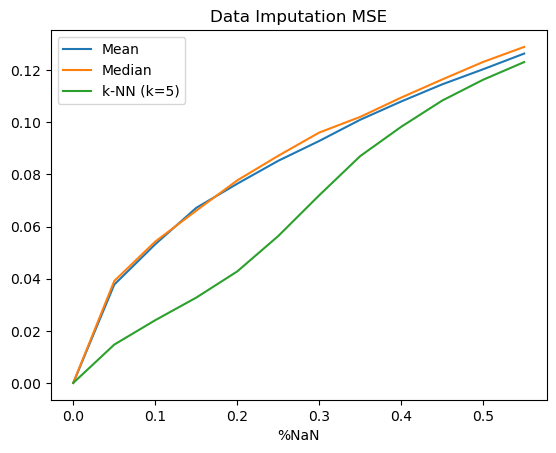

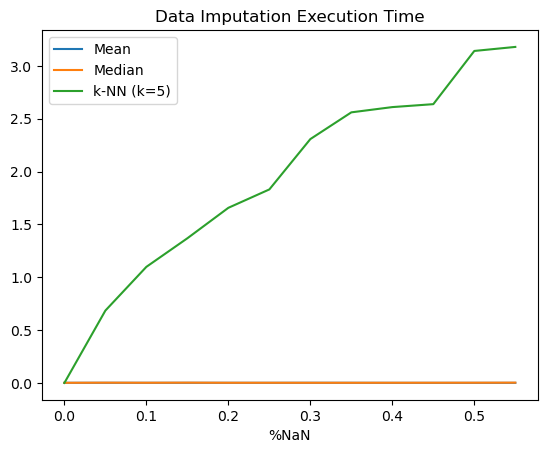

In [23]:
imputation_techniques = [
    (imputation_mean, "Mean"),
    (imputation_median, "Median"),
    (imputation_knn(5), "k-NN (k=5)"),
]
mse_statistic, time_statistic = visualize_evaluation(imputation_techniques)

,Mean,Median,k-NN (k=1),k-NN (k=4),k-NN (k=16),k-NN (k=64),k-NN (k=256),k-NN (k=512)
%NaN,,,,,,,,
0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0.05,0.038047,0.038394,0.015697,0.013074,0.017196,0.020936,0.024229,0.024506
0.10,0.054601,0.056269,0.026363,0.022344,0.024823,0.029899,0.034539,0.036662
0.15,0.065724,0.068626,0.040035,0.032343,0.032578,0.037095,0.042039,0.045381
0.20,0.076580,0.077671,0.060967,0.044580,0.042695,0.046198,0.051059,0.055059
0.25,0.085023,0.086982,0.081731,0.057208,0.052247,0.054913,0.059880,0.062770
0.30,0.094064,0.095510,0.105160,0.074288,0.066389,0.064069,0.066926,0.070238
0.35,0.101107,0.102844,0.126160,0.089720,0.078550,0.074703,0.075669,0.077812
0.40,0.107978,0.109995,0.140685,0.102618,0.088833,0.083492,0.084129,0.085348


,Mean,Median,k-NN (k=1),k-NN (k=4),k-NN (k=16),k-NN (k=64),k-NN (k=256),k-NN (k=512)
%NaN,,,,,,,,
0.00,0.001520,0.002200,0.000968,0.000943,0.000933,0.000931,0.000961,0.000925
0.05,0.002093,0.004521,0.530994,0.519094,0.542441,0.535751,0.548342,0.558500
0.10,0.002051,0.002440,0.950209,0.919323,0.910337,0.944355,0.948762,1.004379
0.15,0.002085,0.002742,1.193458,1.176857,1.234191,1.320643,1.317981,1.406975
0.20,0.002087,0.002658,1.461395,1.492400,1.556850,1.535562,1.626892,1.690268
0.25,0.002116,0.002700,1.684159,1.849566,1.810767,1.817788,1.934133,2.069224
0.30,0.001788,0.002697,1.857440,2.011515,2.213172,2.011811,2.134000,2.336454
0.35,0.001795,0.002770,2.213728,2.417519,2.348541,2.499715,2.529490,2.747780
0.40,0.001870,0.002705,2.449506,2.498822,2.502759,2.965767,2.665443,2.878578


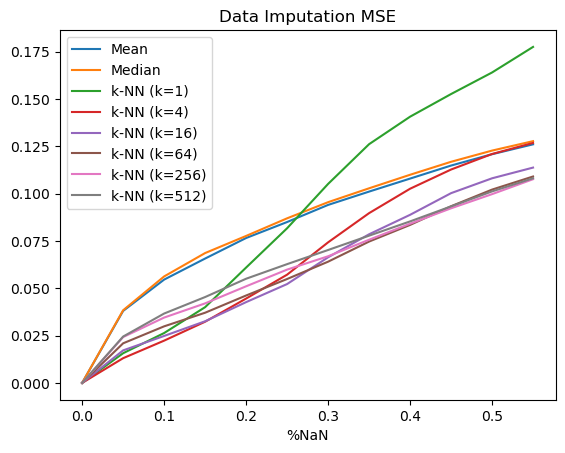

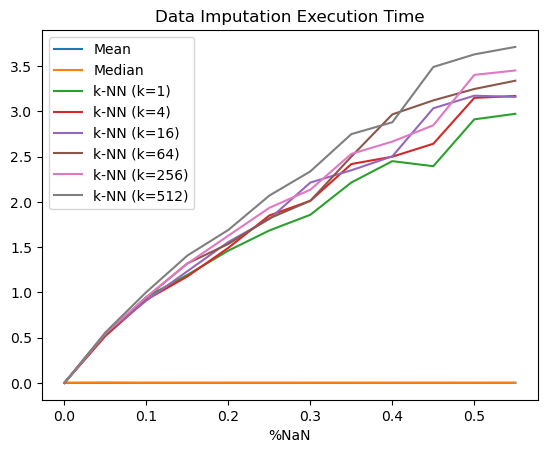

In [24]:
imputation_techniques = [
    (imputation_mean, "Mean"),
    (imputation_median, "Median"),
    (imputation_knn(1), "k-NN (k=1)"),
    #(imputation_knn(2), "k-NN (k=2)"),
    (imputation_knn(4), "k-NN (k=4)"),
    #(imputation_knn(8), "k-NN (k=8)"),
    (imputation_knn(16), "k-NN (k=16)"),
    #(imputation_knn(32), "k-NN (k=32)"),
    (imputation_knn(64), "k-NN (k=64)"),
    #(imputation_knn(128), "k-NN (k=128)"),
    (imputation_knn(256), "k-NN (k=256)"),
    (imputation_knn(512), "k-NN (k=512)")
]
mse_statistic, time_statistic = visualize_evaluation(imputation_techniques)

,Mean,Median,k-NN (k=256),k-NN (k=512),k-NN (k=1024),k-NN (k=2028),k-NN (k=4058),k-NN (k=8132)
%NaN,,,,,,,,
0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0.05,0.038126,0.037880,0.023041,0.023367,0.023866,0.024613,0.022699,0.025731
0.10,0.053969,0.054959,0.033636,0.032922,0.034735,0.034998,0.033348,0.036406
0.15,0.066385,0.065831,0.042937,0.042836,0.043187,0.042813,0.043006,0.047321
0.20,0.076416,0.077551,0.051561,0.051196,0.051135,0.051218,0.051469,0.053855
0.25,0.085958,0.087250,0.059651,0.059612,0.059507,0.060218,0.058243,0.061927
0.30,0.092306,0.093556,0.067136,0.067450,0.069040,0.067091,0.067797,0.070022
0.35,0.100557,0.102502,0.075316,0.074832,0.076487,0.075536,0.076719,0.078253
0.40,0.108232,0.109894,0.083945,0.083775,0.083517,0.084804,0.083717,0.086327


,Mean,Median,k-NN (k=256),k-NN (k=512),k-NN (k=1024),k-NN (k=2028),k-NN (k=4058),k-NN (k=8132)
%NaN,,,,,,,,
0.00,0.002155,0.002175,0.000946,0.000931,0.000998,0.000943,0.000973,0.000942
0.05,0.001601,0.003352,0.553855,0.555571,0.536189,0.533907,0.544074,0.583838
0.10,0.001757,0.002457,1.016902,0.969739,0.996088,0.975585,0.943566,1.010804
0.15,0.001836,0.002417,1.373476,1.340633,1.358969,1.320324,1.316426,1.357615
0.20,0.001771,0.002410,1.643132,1.655729,1.660854,1.631389,1.674165,1.713283
0.25,0.001690,0.002376,1.909120,1.884519,1.972702,1.911224,1.919145,2.040296
0.30,0.001673,0.002997,2.177059,2.140651,2.180181,2.183239,2.145366,2.272539
0.35,0.001757,0.002597,2.549759,2.547134,2.458947,2.501319,2.490094,2.628755
0.40,0.001873,0.002461,2.747093,2.732929,3.002035,2.657111,2.918402,3.157517


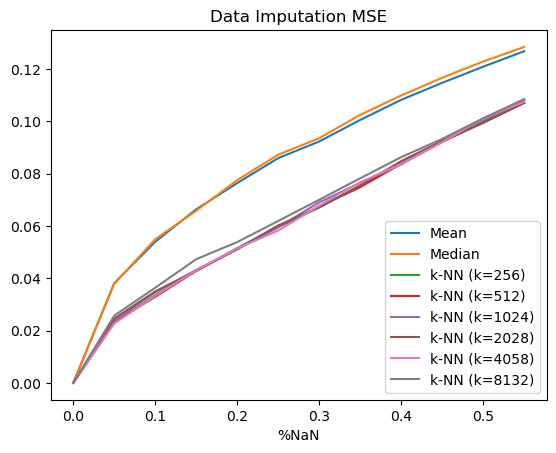

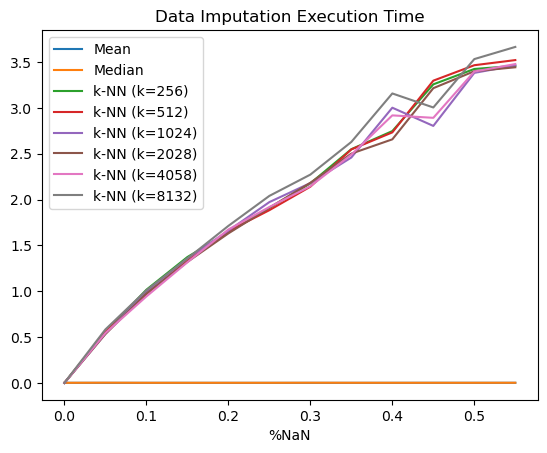

In [25]:
imputation_techniques = [
    (imputation_mean, "Mean"),
    (imputation_median, "Median"),
    (imputation_knn(256), "k-NN (k=256)"),
    (imputation_knn(256), "k-NN (k=512)"),
    (imputation_knn(256), "k-NN (k=1024)"),
    (imputation_knn(256), "k-NN (k=2028)"),
    (imputation_knn(256), "k-NN (k=4058)"),
    (imputation_knn(512), "k-NN (k=8132)")
]
mse_statistic, time_statistic = visualize_evaluation(imputation_techniques)

K-NN with k=4 and k=16 result in the lowest MSE for a dataset with less than 50% missing data! If time matters, simply using the mean is definitely the best choice!

/opt/homebrew/Caskroom/miniforge/base/envs/Master_Project/lib/python3.8/site-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/Master_Project/lib/python3.8/site-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/Master_Project/lib/python3.8/site-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/Master_Project/lib/python3.8/site-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/Master_Project/lib/python3.8/site-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [Ite

,Mean,Median,k-NN (k=16),MICE
%NaN,,,,
0.00,0.000000,0.000000,0.000000,0.000000
0.05,0.039162,0.038793,0.016942,0.023050
0.10,0.053106,0.055455,0.025283,0.032456
0.15,0.066029,0.068296,0.033024,0.041330
0.20,0.076407,0.077438,0.041956,0.048122
0.25,0.085897,0.087688,0.054004,0.058125
0.30,0.093363,0.096130,0.066097,0.070513
0.35,0.101324,0.103011,0.077615,0.073417
0.40,0.107728,0.110561,0.087354,0.083561


,Mean,Median,k-NN (k=16),MICE
%NaN,,,,
0.00,0.001877,0.003231,0.000953,0.047126
0.05,0.001766,0.002645,0.568044,1.541593
0.10,0.001788,0.002934,0.938812,1.554272
0.15,0.001802,0.002720,1.208103,1.589987
0.20,0.001735,0.002638,1.531323,1.574454
0.25,0.001784,0.002718,1.844219,1.537402
0.30,0.001766,0.002724,1.988122,1.446938
0.35,0.001893,0.002619,2.396716,1.454018
0.40,0.002403,0.003002,2.422011,1.344640


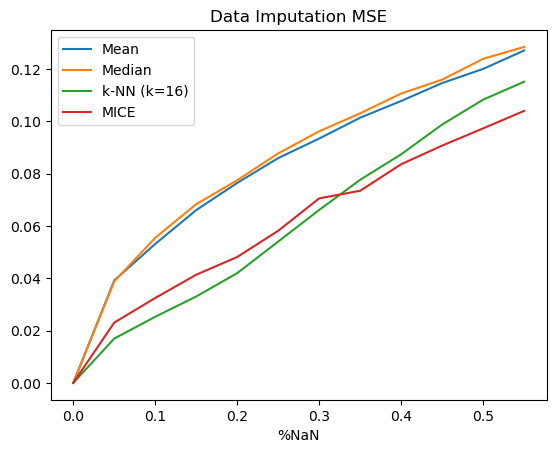

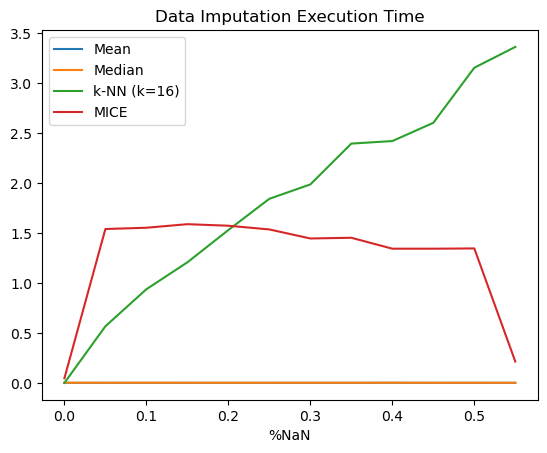

In [26]:
imputation_techniques = [
    (imputation_mean, "Mean"),
    (imputation_median, "Median"),
    (imputation_knn(16), "k-NN (k=16)"),
    (imputation_mice, "MICE")
]
mse_statistic, time_statistic = visualize_evaluation(imputation_techniques)

# RESULT:
- k-NN and MICE increase the precision of the imputation
- The MSE of k-NN is about the half the mean-MSE.
- Performance of mean and median is almost the same, mean is slightly better on high % of NaN.
- Since mean and median are significantly faster than k-NN and MICE, we will use mean!


# Questions /TODOs
- Should I also test it on bigger datasets?
- It seems like the MSE is tiny for all methods. Is this the correct interpretation?
- The data is normalized to 0-1. A MSE of 0.1 means that the imputed values in average differ by 10% of the true value. Is this correct?